# A Project on Customer Retention, by CAN ICOZ

Customer retention is an important metric in business that significantly affects revenue. For instance, a low rate of customers' retention causes an increase in cost of marketing. If a company is selling online, like the one in here, customers' behavior can be tracked by using their visit dates. In this project, I will calculate several measures of customer retention to see patterns in customer visits to the website of an online seller.

There are two datasets from a real company and four tasks. The datasets are the following:

- signups.csv (sample size 71989) has 4 columns, named as: 'uid' (number, unique user id for each customer), 'signup_dt' (string, signup date of a customer), 'auth_type' (categorical, authentication type, three values A, B, and C), and 'device' (categorical, device used for signing up, seven values from 1 to 7)


- visits.csv (sample size 1028813) has 2 columns, named as: 'uid' (user id of customer who visited the website), and 'dt' (string, date of visiting website).

Note: 'uid' can repeat in visits.csv as a customer can visit website more than once. But, 'uid' cannot repeat in signups.csv.



Before starting, need to import necessary modules:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Now, reading two datasets:

In [2]:
sdf=pd.read_csv("signups.csv") #data for website signups
vdf=pd.read_csv("visits.csv") #data for website visits

Structure of this notebook: 

Each task will be performed in a seperate section. Sections include description of the task, along with calculation of measures, tables, and plots. After each calculation, I will comment on the results.

### TASK 1 - Percent distribution with respect to device, authentication type, and (device,authentication) combination used for signing up

In this task, I will calculate and plot the frequency distributions of devices, authentication type, and their combination when customers used for signing up to the website. (So, there will be three distributions.)

First, calculation of series:

In [3]:
device_percent=100*(sdf['device'].value_counts() / len(sdf['device'])) #device
auth_percent=100*(sdf['auth_type'].value_counts() / len(sdf['auth_type'])) #auth type
dev_auth_percent=100*(sdf.groupby(['device','auth_type']).size())/len(sdf) # dev, auth combination

Then, plotting the series:

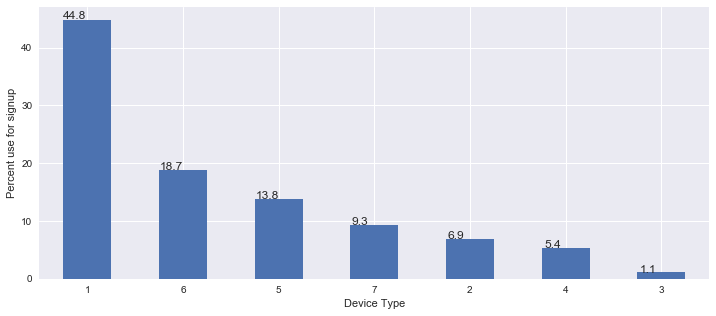

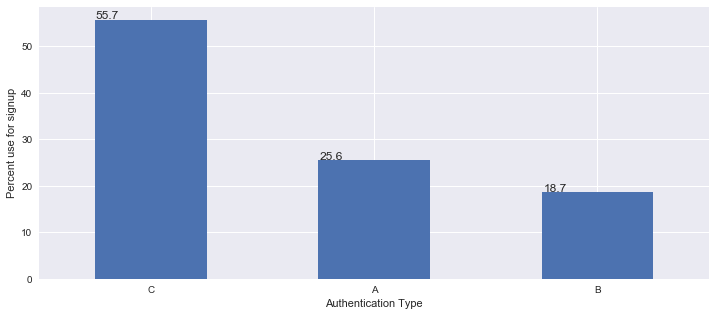

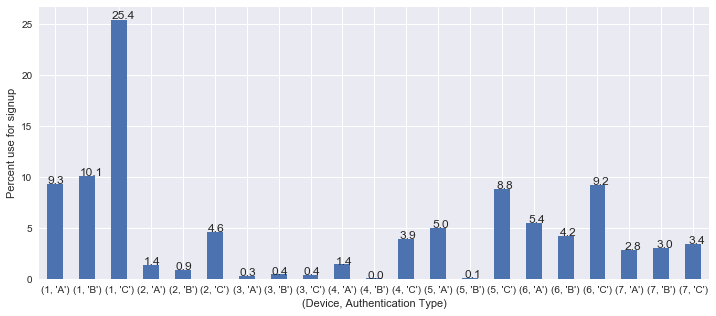

In [4]:
fig_size=[12.0,5.0] #change figure size, make them wider
plt.rcParams["figure.figsize"] = fig_size

val_list=[device_percent, auth_percent,dev_auth_percent] #three series to plot
name_list=['Device Type','Authentication Type','(Device, Authentication Type)'] #names of three series
for i,l in enumerate(val_list): #for loop for plotting
    ax = l.plot(kind='bar')
    xlab=[str(x) for x in list(val_list[i].index)]
    plt.draw()
    for p in ax.patches:
        height=round(p.get_height(),1)
        ax.annotate(str(height), (p.get_x() * 1.005, p.get_height() * 1.005))
        ax.set_xlabel(name_list[i])
        ax.set_ylabel('Percent use for signup')
        ax.set_xticklabels(xlab,rotation=0)
    plt.show()
plt.close()

Comments:

1) The first plot above shows that device_1 is by far the most used device that people used for signing up. Almost half of the people (44.8%) used device_1. It is followed by device_6 and device_5.

2) The second plot suggests authentication type "C" is the most used. Its percent usage is even bigger than the sum of other two types'.

3) As to (device, authentication type) pair, most common combination is (1,C); around one quarter of people used that combination.

### TASK 2 - Percent(%) website visiting during nth week after sign up

In this section, I need to calculate what percent of customers visit the website after signing up during the period from 6/1 to 10/30. The aim is to have a table such that:
- Indexed by signup date
- First column is total number of sign up at each date between 6/1 to 10/30 (five months period)
- Other columns are % visits of signed up customers during the nth week after signup. (n=1,2,..., 26)

Please note the following:
- If a customer visits the website three times during the same week, only one of them is counted. In other words, we are not calculating total number of visits, but calculating whether a customers visits website or not at the nth week after signing up.

- The start and end days of the week depend on the signup date. For instance, if a customer signed up on Wednesday, the first day of the week for her is Thursday. And the second week of her starts on next Thursday.

Since there are two data sets, one is signup data and the other is website visits, we need to merge them first on user id.

In [5]:

mdf=pd.merge(sdf,vdf, on='uid') #merging visit and signup dfs on uid(user id)


Please note that uid can repeat in merged dataframe (mdf) since it repeats in visits dataframe (vdf), because a customer may visit the website more than once after signing up.

There are two date columns in the merged dataframe ("signup_dt" and "dt"), but their type is not date in Python language. So, I need to format those columns as date:

In [6]:
mdf["signup_dt"]=pd.to_datetime(mdf["signup_dt"]).dt.date #converting "signup_dt" column to date format
mdf["dt"]=pd.to_datetime(mdf["dt"]).dt.date  #converting "dt" column to date format

Since I only look for a certain period (from 6/1 to 10/30), I need to slice dataframe:

In [7]:
start=datetime.date(2016, 6, 1)
end=datetime.date(2016, 10, 30)
date_condition=(mdf["signup_dt"]>=start)&(mdf["signup_dt"]<=end)
mdf=mdf[date_condition]

Now, need to calculate number of weeks since signup date:

In [8]:
mdf["weeks"]=np.ceil(((mdf["dt"]-mdf["signup_dt"]).astype('timedelta64[D]'))/7)

Let's check how merged dataframe looks like:

In [9]:
print("shape of merged dataframe", mdf.shape)
print("columns of merged dataframe",list(mdf.columns))

shape of merged dataframe (1005833, 6)
columns of merged dataframe ['uid', 'signup_dt', 'auth_type', 'device', 'dt', 'weeks']


Here is an important point:

Since a customer may visit the website more than once in a given week, there are many duplicates of (uid, week) pair. For instance, if a customer (with user id 777) signs up on 6/1 and visited the website on 6/5, 6/10 and 6/11, then there will be rows that include pairs (uid, weeks) such that (777,1), (777,2), and (777,2). So, one of the (777,2) pair must be removed.

In other words, I am only interested in whether a customer visits the website during nth week after sign up. If she does, count (how many times she visited during nth week) does not matter.

In [10]:
mdf = mdf.drop_duplicates(["uid","weeks"]) #removing duplicates

Now, I am ready to calculate the table that is described at the beginning of this section:

In [11]:
tab1=mdf.groupby('signup_dt').weeks.apply(lambda g: (g==0).sum()) #calculating total signups (first column)
total_signup=tab1 #keeping first col as series, since it will be needed later

for i in range(1,27): #calculating other columns (% customer visit for each week)
    week_i=round((100*(mdf.groupby('signup_dt').weeks.apply(lambda g: (g==i).sum()))/total_signup),2)
    tab1=pd.concat([tab1, week_i], axis=1)
tab1=pd.DataFrame(tab1)

#renaming columns
numweek=list(range(1,27))
numweek=[str(x) for x in numweek]
new_col=["Total_Signups"]+["Week_"+ s for s in numweek]
tab1.columns=new_col

Here is how the table for this task looks like:

In [12]:
print("% Visits for nth week after sign up ")
tab1.head()

% Visits for nth week after sign up 


,Total_Signups,Week_1,Week_2,Week_3,Week_4,Week_5,Week_6,Week_7,Week_8,Week_9,...,Week_17,Week_18,Week_19,Week_20,Week_21,Week_22,Week_23,Week_24,Week_25,Week_26
signup_dt,,,,,,,,,,,,,,,,,,,,,
2016-06-01,400,59.75,40.00,33.25,31.50,27.00,24.50,25.50,25.75,23.25,...,15.75,15.50,14.75,15.75,14.50,15.00,15.00,12.50,10.50,14.25
2016-06-02,439,66.74,42.82,37.59,32.80,28.70,29.61,26.20,23.23,24.37,...,17.08,18.45,16.86,18.00,16.40,16.86,15.49,13.21,12.76,14.12
2016-06-03,407,68.06,43.24,32.19,36.36,33.42,23.59,28.26,25.55,22.85,...,16.22,17.69,15.72,14.99,15.48,16.46,15.48,13.76,17.20,16.46
2016-06-04,436,67.20,47.02,42.43,38.07,32.80,31.42,31.19,27.75,27.29,...,21.56,19.50,18.81,19.04,13.76,17.20,16.51,16.28,16.74,18.58
2016-06-05,540,62.41,42.59,36.85,33.70,34.81,28.15,27.59,23.89,23.33,...,18.70,20.37,18.89,15.93,16.30,17.22,15.00,13.33,16.11,14.07


As expected, majority of customers visit the website during the first week after signing up. But then they visit less during the second week. In general, percent of customer visits decrease as the number of weeks since signup increases.

Since it is difficult to present whole table here, another tecnique to display the result would be more useful. Now, I will use a data visualization tecnhique, heatmap, to present the result: 
(all columns but the first, since the first column is just total number of signups)

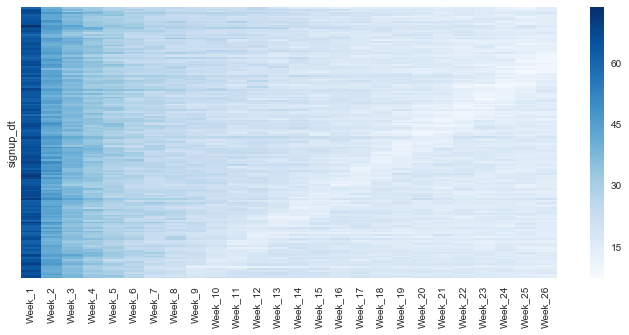

In [13]:
sns.heatmap(tab1.iloc[:,1:27],yticklabels=False,cmap="Blues")
plt.show()

The above heatmap suggests that:
- The first week after signup is the week at which customer visit the website most.
- Between 2-4 weeks, there is still significant amount of visits (30-40%), although less than the first week.
- Starting around weeks 7-10, visits tend to stay at low levels.

The last measure to look in this section is percent of customers who "never" visited the website after signing up. How can we get this measure? If a customer just signs up and never visited, then the maximum value in "weeks" column (which is number of weeks between sign up date and visit date) will be 0.

In [14]:
mdf["max_week"]=mdf['weeks'].groupby(mdf['uid']).transform('max')
never_visited=round((100*sum(mdf['max_week']==0)/mdf.shape[0]),2)
print(never_visited,"% of customers never visited the website after signing up")

1.46 % of customers never visited the website after signing up


### TASK 3 - Retention by authentication type

As expected, customers visits are decreasing as the time since sign up increases. Does the rate of decrease in website visits vary by the authentication type that customers use for signing up? Let's check this for two random dates, one for July and one for August:

In [15]:
date1=datetime.date(2016, 7, 24) #random date in July
date2=datetime.date(2016, 8, 18) #random date in August
date_condition=((mdf["signup_dt"]==date1) | (mdf["signup_dt"]==date2))
subdf=mdf[date_condition] #filtering data (just for two days)

#constructing a dataframe
tab2=subdf.groupby(['signup_dt','auth_type']).weeks.apply(lambda g: (g==0).sum())
total_signup2=tab2
for i in range(1,27): #calculating other columns (% visit for each week)
    week_i=100*(subdf.groupby(['signup_dt','auth_type']).weeks.apply(lambda g: (g==i).sum()))/total_signup2
    tab2=pd.concat([tab2, week_i], axis=1)
tab2=pd.DataFrame(tab2)

#renaming columns
tab2.columns=new_col

Here is how our table for this task looks like:

In [16]:
tab2.head(n=6)

Total_Signups     Week_1     Week_2     Week_3  \
signup_dt  auth_type                                                   
2016-07-24 A                    145  63.448276  39.310345  35.172414   
           B                    102  71.568627  41.176471  35.294118   
           C                    283  64.664311  49.469965  37.809187   
2016-08-18 A                    102  68.627451  50.980392  38.235294   
           B                     78  64.102564  47.435897  43.589744   
           C                    229  69.868996  48.908297  43.668122   

                         Week_4     Week_5     Week_6     Week_7     Week_8  \
signup_dt  auth_type                                                          
2016-07-24 A          35.172414  27.586207  26.206897  24.137931  21.379310   
           B          33.333333  28.431373  25.490196  24.509804  27.450980   
           C          35.335689  31.448763  28.975265  30.035336  28.621908   
2016-08-18 A          35.294118  32.352941  24.509804  23.529412  26.470588   
           B          32.051282  30.769231  32.051282  32.051282  34.615385   
           C          37.991266  30.131004  22.270742  27.947598  25.764192   

                         Week_9    ...        Week_17    Week_18    Week_19  \
signup_dt  auth_type               ...                                        
2016-07-24 A          20.000000    ...      19.310345  16.551724  11.724138   
           B          20.588235    ...      18.627451  20.588235  20.588235   
           C          22.261484    ...      21.554770  20.141343  22.968198   
2016-08-18 A          23.529412    ...      19.607843  17.647059  13.725490   
           B          29.487179    ...      21.794872  12.820513  17.948718   
           C          21.834061    ...      20.087336  14.847162  10.480349   

                        Week_20    Week_21    Week_22    Week_23    Week_24  \
signup_dt  auth_type                                                          
2016-07-24 A          16.551724  15.172414  11.034483  12.413793  11.724138   
           B          13.725490  15.686275  11.764706  13.725490   8.823529   
           C          16.607774  15.194346  11.660777  12.720848  16.254417   
2016-08-18 A           7.843137  13.725490  19.607843  25.490196  14.705882   
           B          16.666667  17.948718  15.384615  17.948718  19.230769   
           C          16.157205  14.847162  18.340611  14.847162  18.777293   

                        Week_25    Week_26  
signup_dt  auth_type                        
2016-07-24 A          13.793103  12.413793  
           B          13.725490  13.725490  
           C          20.141343  16.254417  
2016-08-18 A          17.647059  13.725490  
           B          20.512821  12.820513  
           C          17.467249  16.157205  

[6 rows x 27 columns]

To see whether % visits change by auth_type or nor, let's visualize this table by two plots:

Percent website visits since sign up by authentication type (For sign up date 7/24)



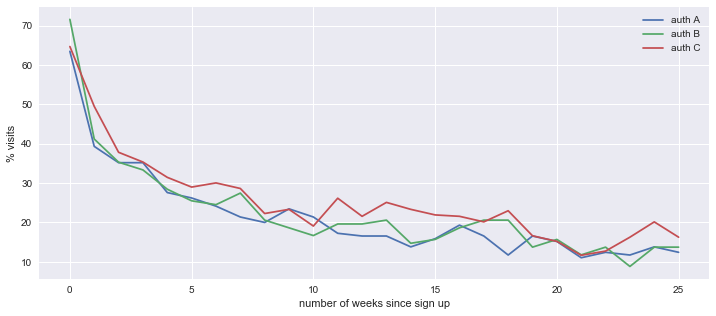


Percent website visits since sign up by authentication type (For sign up date 8/18)



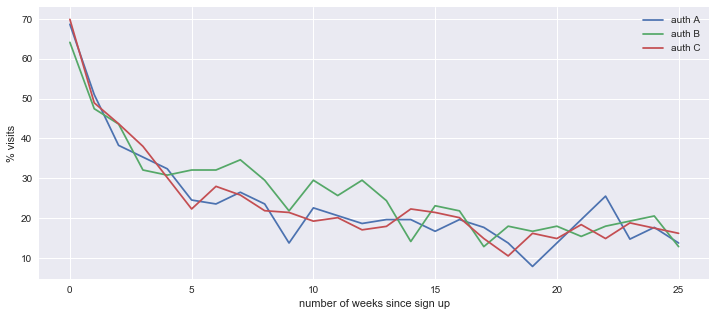

In [17]:
A_july=np.array(tab2.iloc[0,1:27])
B_july=np.array(tab2.iloc[1,1:27])
C_july=np.array(tab2.iloc[2,1:27])

A_aug=np.array(tab2.iloc[3,1:27])
B_aug=np.array(tab2.iloc[4,1:27])
C_aug=np.array(tab2.iloc[5,1:27])

def retention_plot(arr1,arr2,arr3):
    line1,=plt.plot(arr1)
    line2,=plt.plot(arr2)
    line3,=plt.plot(arr3)
    plt.xlabel("number of weeks since sign up")
    plt.ylabel("% visits")
    plt.legend((line1, line2, line3), ('auth A', 'auth B', 'auth C'))
    plt.show()

print("Percent website visits since sign up by authentication type (For sign up date 7/24)\n")
retention_plot(A_july,B_july,C_july)
print("\nPercent website visits since sign up by authentication type (For sign up date 8/18)\n")
retention_plot(A_aug,B_aug,C_aug)

The two figures above suggest that:

- There doesn't seem to be a significant difference in retention across authentication types. This is true for both of the two days.

- After around week 10, customer visits continue at low levels and show more or less stable patterns.

### Task 4 - Percent customer visiting for the first time

Another important measure would be this: what proportion of customers came back after signing up, for the first time within the nth week after signup? This task is a slightly different task 2. In task 2, I tracked every visits of customers during the nth week after signup. However, in here, I am only interested in "the first visit" after signup.

Here is how I think here: the "weeks" column of the merged dataframe (mdf), which was calculated in task 2 above, shows number of weeks between signup and a visit. If a customer has only 0 (zero) in that column, this means that the customer just signed up and never came back. Therefore, I can calculate the first visit after signup by following three steps:

- Step 1: Remove rows that has 0 in "weeks" column.
- Step 2: Calculate the min of "weeks' column (call it "min_week") for each customer (each user id)
- Step 3: Remove (uid, min_week) duplicates. (If a customer visits the website more than one times during the week of her first visit, then there will be duplicates which must be removed).

Here is the code for these three steps:

In [18]:
subdf=mdf[mdf["weeks"]>0]
subdf["min_week"]=subdf['weeks'].groupby(subdf['uid']).transform('min')
subdf = subdf.drop_duplicates(["uid","min_week"])

tab3=total_signup

for i in range(1,27): #calculating other columns (% visit for each week)
    week_i=100*(subdf.groupby('signup_dt').min_week.apply(lambda g: (g==i).sum()))/total_signup
    tab3=pd.concat([tab3, week_i], axis=1)
tab3=pd.DataFrame(tab3)
new_col=["Total_Signups"]+["%_First_Visit_Week_"+ s for s in numweek]
tab3.columns=new_col

Here is how our table for this task looks like:

In [19]:
tab3.head(n=6)

,Total_Signups,%_First_Visit_Week_1,%_First_Visit_Week_2,%_First_Visit_Week_3,%_First_Visit_Week_4,%_First_Visit_Week_5,%_First_Visit_Week_6,%_First_Visit_Week_7,%_First_Visit_Week_8,%_First_Visit_Week_9,...,%_First_Visit_Week_17,%_First_Visit_Week_18,%_First_Visit_Week_19,%_First_Visit_Week_20,%_First_Visit_Week_21,%_First_Visit_Week_22,%_First_Visit_Week_23,%_First_Visit_Week_24,%_First_Visit_Week_25,%_First_Visit_Week_26
signup_dt,,,,,,,,,,,,,,,,,,,,,
2016-06-01,400,59.750000,8.500000,3.250000,3.250000,2.250000,1.250000,1.000000,1.500000,0.250000,...,0.250000,0.250000,0.250000,0.000000,0.25,0.00000,0.00000,0.000000,0.500000,0.000000
2016-06-02,439,66.742597,5.922551,4.783599,1.138952,1.366743,0.683371,0.911162,0.227790,0.683371,...,0.000000,0.455581,0.227790,0.227790,0.00,0.22779,0.00000,0.000000,0.000000,0.227790
2016-06-03,407,68.058968,8.845209,2.948403,2.457002,0.982801,0.737101,0.491400,0.737101,0.245700,...,0.000000,0.000000,0.000000,0.491400,0.00,0.00000,0.24570,0.000000,0.000000,0.000000
2016-06-04,436,67.201835,7.798165,2.752294,3.211009,1.376147,0.458716,0.458716,0.458716,0.917431,...,0.229358,0.458716,0.229358,0.229358,0.00,0.00000,0.00000,0.458716,0.000000,0.229358
2016-06-05,540,62.407407,5.925926,3.148148,2.777778,3.333333,1.481481,1.296296,0.000000,1.296296,...,0.740741,0.185185,0.185185,0.185185,0.00,0.00000,0.37037,0.000000,0.185185,0.370370
2016-06-06,463,63.282937,7.775378,4.967603,2.591793,1.943844,0.647948,0.647948,1.511879,0.647948,...,0.000000,0.215983,0.000000,0.000000,0.00,0.00000,0.00000,0.431965,0.000000,0.000000


According to above table, around 60-70% of the customers (on average) visit the website first time during the first week after sign up, and around 7-8% (on average) during the second week.

# THE END